
<div class="note">
    <p style="margin-top: 0; margin-bottom: 0;">
        <img style="margin-top: 0; margin-bottom: 0; height: 2em;" class="inline-block mr-2 no-fancybox"
            src="https://upload.wikimedia.org/wikipedia/commons/3/38/Jupyter_logo.svg" alt="">
        This page is based on a Jupyter notebook.
<a href="./beam.ipynb" download="beam.ipynb"><img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" src="https://img.shields.io/static/v1?label=Download:&message=beam.ipynb&color=blue" /></a>
<a href="https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/PhaseField/beam_jupyter_notebook/beam.py"><img src="https://img.shields.io/static/v1?label=Source:&message=beam.py&color=brightgreen" class="no-fancybox"
        style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" /></a>
<a href="https://binder.opengeosys.org/v2/gh/bilke/binder-ogs-requirements/master?urlpath=git-pull%3Frepo=https://gitlab.opengeosys.org/ogs/ogs%26urlpath=lab/tree/ogs/Tests/Data/PhaseField/beam_jupyter_notebook/beam.py%26branch=master%26depth=1">
    <img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;"
        src="https://img.shields.io/static/v1?label=&message=Launch notebook&color=5c5c5c&logo=" />
</a></p></div>


## Problem description

In this example, it is shown, how phasefield models can be applied to simulate crack initiation.
Consider a bar $\Omega=[0,1]\times [0,0.05]\times [0,0.05]$ where the left end $\partial \Omega_{Left}$ is fixed and a displacement $U_x(t)$ is applied to the right end $\partial \Omega_{Right}$, resulting in a uniaxial state of stress $\boldsymbol{\sigma} = \sigma_{33} \, \mathbf{n}_3 \otimes \mathbf{n}_3$. At a certain point, fracture will initiate resulting in failure of the beam. $\newline$ This will be examined for positive $U_x(t)$ (tensile stress) and for negative $U_x(t)$ (compressive stress). As energy-split models the Isotropic and the Volumetric Deviatoric are used and as phasefield models $\texttt{AT}_1$ and $\texttt{AT}_2$. So in total 8 different cases are tested.
The aim is to estimate the ultimate load before fracture initiates for each case, as this can be veryfied against analytical results.

![Schematic view of beam](./figures/bar_.png#one-half "Schematic view of beam.")

Also considering homogeneous damage development (i.e.$\nabla v = 0$), the analytical solution for the strengths under uniaxial tension and compression are as follows.

|   | Isotropic | Vol-Dev |
|:---:|:---:|:---:|
|Tensile $$\texttt{AT}_1$$| $$\sqrt{ \dfrac{3 G_\mathrm{c} E} {8 \ell}}$$| $$\sqrt{\dfrac{3 G_\mathrm{c} E}{8 \ell}}$$  |
|Tensile $$\texttt{AT}_2$$| $$ \dfrac{3}{16}  \sqrt{ \dfrac{3 G_\mathrm{c} E } { \ell}}$$ | $$\dfrac{3}{16} \sqrt{\dfrac{3 G_\mathrm{c} E}{\ell}}$$ |
|Compressive $$\texttt{AT}_1$$|  $$-\sqrt{ \dfrac{3 G_\mathrm{c} E} {8 \ell}}$$  |  $$- \sqrt{ \dfrac{9 G_\mathrm{c} E} {16 \ell(1+\nu)}}$$ |
|Compressive $$\texttt{AT}_2$$| $$ -\dfrac{3}{16}  \sqrt{ \dfrac{3 G_\mathrm{c} E } { \ell}}$$  | $$ -\dfrac{9}{32} \sqrt{\dfrac{2 G_\mathrm{c} E}{ \ell (1+\nu)}}$$ |

## Define some helper functions

In [1]:
import os
import time
from pathlib import Path
from subprocess import run
from types import MethodType
from xml.dom import minidom

import matplotlib.pyplot as plt
import numpy as np
import ogstools as ot
import pyvista as pv

In [2]:
data_dir = os.environ.get("OGS_DATA_DIR", "../../..")

out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
if not out_dir.exists():
    out_dir.mkdir(parents=True)

output_dir = out_dir

# define method to be assigned to model, to replace a specific curve, given by name
# (analogue to replace_parameter method)


def replace_curve(
    self,
    name=None,
    value=None,
    coords=None,
    parametertype=None,
    valuetag="values",
    coordstag="coords",
):
    root = self._get_root()
    parameterpath = "./curves/curve"
    parameterpointer = self._get_parameter_pointer(root, name, parameterpath)
    self._set_type_value(parameterpointer, value, parametertype, valuetag=valuetag)
    self._set_type_value(parameterpointer, coords, parametertype, valuetag=coordstag)


# define method to change timstepping in project file


def set_timestepping(model, repeat_list, delta_t_list):
    model.remove_element(
        xpath="./time_loop/processes/process/time_stepping/timesteps/pair"
    )
    for i in range(len(repeat_list)):
        model.add_block(
            blocktag="pair",
            parent_xpath="./time_loop/processes/process/time_stepping/timesteps",
            taglist=["repeat", "delta_t"],
            textlist=[repeat_list[i], delta_t_list[i]],
        )

## Define function generating mesh, modifying project file and running ogs with given parameters

In [3]:
def ogs_beam(
    phasefield_model,
    energy_split_model,
    mesh_size=0.01,
    length_scale=0.02,
    bc_displacement=5,
    ts_coords="0 0.05 1",
    values="0 0.25 1",
    repeat_list=None,
    delta_t_list=None,
    hypre=False,
):
    ##phasefield_model: 'AT1' or 'AT2'
    ##energy_split_model: 'VolumetricDeviatoric' or 'Isotropic'

    without_hypre = "-ksp_type cg -pc_type bjacobi -ksp_atol 1e-14 -ksp_rtol 1e-14"
    with_hypre = "-ksp_type cg -pc_type hypre -pc_hypre_type boomeramg -pc_hypre_boomeramg_strong_threshold 0.7 -ksp_atol 1e-8 -ksp_rtol 1e-8"
    # file's name
    prj_name = "beam.prj"
    print(f"> Running beam model {phasefield_model} - {energy_split_model} ... <")
    logfile = f"{out_dir}/log_{phasefield_model}_{energy_split_model}.txt"
    # beam dimensions
    beam_height = 0.05
    beam_depth = beam_height
    beam_length = 1.0
    # mesh properties
    h = mesh_size
    ls = length_scale
    # generate prefix from properties
    if energy_split_model == "VolumetricDeviatoric":
        prefix = phasefield_model + "_vd"
    elif energy_split_model == "Isotropic":
        prefix = phasefield_model + "_iso"
    else:
        raise ValueError(
            '"'
            + energy_split_model
            + '"'
            + ' is no valid input for energy_split_model, choose between "VolumetricDeviatoric" and "Isotropic"'
        )
    if bc_displacement > 0:
        prefix = prefix + "_tensile"
    else:
        prefix = prefix + "_compressive"
    # generate mesh
    run(
        f"generateStructuredMesh -o {out_dir}/bar_.vtu -e hex --lx {beam_length} --nx {round(beam_length/h)} --ly {beam_height} --ny {round(beam_height/h)} --lz {beam_depth} --nz {round(beam_depth/h)} > {logfile}",
        check=True,
        shell=True,
    )
    run(
        f"NodeReordering -i {out_dir}/bar_.vtu -o {out_dir}/bar.vtu >> {logfile}",
        check=True,
        shell=True,
    )
    run(
        f"ExtractSurface -i {out_dir}/bar.vtu -o {out_dir}/bar_left.vtu -x 1 -y 0 -z 0 >> {logfile}",
        check=True,
        shell=True,
    )
    run(
        f"ExtractSurface -i {out_dir}/bar.vtu -o {out_dir}/bar_right.vtu -x -1 -y 0 -z 0 >> {logfile}",
        check=True,
        shell=True,
    )
    run(
        f"partmesh -s -o {out_dir} -i {out_dir}/bar.vtu >> {logfile}",
        check=True,
        shell=True,
    )
    run(
        f"partmesh -m -n 3 -o {out_dir} -i {out_dir}/bar.vtu -- {out_dir}/bar_right.vtu {out_dir}/bar_left.vtu >> {logfile}",
        check=True,
        shell=True,
    )
    # change properties in prj file
    model = ot.Project(
        input_file=prj_name, output_file=f"{out_dir}/{prj_name}", MKL=True
    )
    model.replace_parameter_value(name="ls", value=ls)
    model.replace_text(phasefield_model, xpath="./processes/process/phasefield_model")
    model.replace_text(
        energy_split_model, xpath="./processes/process/energy_split_model"
    )
    model.replace_text(prefix, xpath="./time_loop/output/prefix")
    model.replace_parameter_value(name="dirichlet_right", value=bc_displacement)
    model.replace_curve = MethodType(replace_curve, model)
    model.replace_curve(name="dirichlet_time", value=values, coords=ts_coords)
    if repeat_list is not None and delta_t_list is not None:
        set_timestepping(model, repeat_list, delta_t_list)
    else:
        set_timestepping(model, ["1"], ["1e-2"])
    if hypre is True:
        model.replace_text(
            with_hypre,
            xpath="./linear_solvers/linear_solver/petsc/parameters",
            occurrence=1,
        )
    else:
        model.replace_text(
            without_hypre,
            xpath="./linear_solvers/linear_solver/petsc/parameters",
            occurrence=1,
        )
    model.write_input()
    # run ogs
    t0 = time.time()
    print("  > OGS started execution ...")
    run(
        f"mpirun -n 3 ogs {out_dir}/{prj_name} -o {output_dir} >> {logfile}",
        check=True,
        shell=True,
    )
    tf = time.time()
    print("  > OGS terminated execution. Elapsed time: ", round(tf - t0, 2), " s.")

## Input data

The values of the material properties are choosen as follows.


| **Name**                       | **Value**          | **Unit**     | **Symbol** |
|--------------------------------|--------------------|--------------|------------|
| _Young's modulus_              | 1                  | Pa          | $E$        |
| _Critical energy release rate_ | 1                  | Pa$\cdot$m | $G_{c}$    |
| _Poisson's ratio_              | 0.15               | $-$          | $\nu$      |
| _Regularization parameter_     | 3$h$               | m           | $\ell$     |
| _Length_                       | $1$                | m           | $L$        |
| _Height_                       | $0.05$             | m           | $H$        |
| _Depth_                        | $0.05$             | m           | $D$        |


## Run Simulations

In [4]:
pf_ms = ["AT1", "AT2"]
es_ms = ["VolumetricDeviatoric", "Isotropic"]
displ = [4.0, -4.0]
"""
for a in pf_ms:
    for c in displ:
         ogs_beam(a,es_ms[1],bc_displacement = c,mesh_size = 0.01, length_scale = 0.03)
ogs_beam(pf_ms[1],es_ms[0],bc_displacement = 4,mesh_size = 0.01, length_scale = 0.03)

# run AT1_vd_tensile with smaller timesteps in critical time range
ogs_beam(pf_ms[0],es_ms[0],bc_displacement = 5,mesh_size = 0.01, length_scale = 0.03,repeat_list=['62','2','20','1'], delta_t_list=['1e-2','1e-3','1e-4','1e-2'])

# run VolumetricDeviatoric in Compression with Hypre and smaller timesteps in critical time range
ogs_beam(pf_ms[1],es_ms[0],bc_displacement = -4.5,mesh_size = 0.01, length_scale = 0.03, hypre = True, repeat_list=['70','4','30','1'], delta_t_list=['1e-2','1e-3','1e-4','1e-2'])

# loosen relative error tolerance for displacement process in order to get convergence for the AT1 case
prj_path='./'
prj_name = "beam.prj"
model = ot.Project(input_file=prj_path+prj_name, output_file=prj_path+prj_name, MKL=True)
model.replace_text('1e-6', xpath="./time_loop/processes/process/convergence_criterion/reltol",occurrence=0)
model.write_input()
ogs_beam(pf_ms[0],es_ms[0],bc_displacement = -4.95, mesh_size = 0.01, length_scale = 0.03, hypre= True, repeat_list=['66', '8','3','3','20','1'], delta_t_list=['1e-2','1e-3','1e-4','1e-5','1e-6','1e-2'],ts_coords='0 0.1 1', values ='0 0.5 1')
model = ot.Project(input_file=prj_path+prj_name, output_file=prj_path+prj_name, MKL=True)
model.replace_text('1e-14', xpath="./time_loop/processes/process/convergence_criterion/reltol",occurrence=0)
model.write_input()
"""
## run only cases easy to handle with coarse timestepping:
for a in pf_ms:
    for b in es_ms:
        for c in displ:
            if a == "AT1" and b == "VolumetricDeviatoric":
                continue
            if a == "AT2" and b == "VolumetricDeviatoric" and c < 0:
                ogs_beam(
                    a,
                    b,
                    bc_displacement=c,
                    mesh_size=0.01,
                    length_scale=0.03,
                    hypre=True,
                    repeat_list=["1"],
                    delta_t_list=["1e-1"],
                )
            else:
                ogs_beam(
                    a,
                    b,
                    bc_displacement=c,
                    mesh_size=0.01,
                    length_scale=0.03,
                    repeat_list=["1"],
                    delta_t_list=["1e-1"],
                )

> Running beam model AT1 - Isotropic ... <


  > OGS started execution ...


  > OGS terminated execution. Elapsed time:  7.2  s.
> Running beam model AT1 - Isotropic ... <


  > OGS started execution ...


  > OGS terminated execution. Elapsed time:  6.84  s.
> Running beam model AT2 - VolumetricDeviatoric ... <


  > OGS started execution ...


  > OGS terminated execution. Elapsed time:  17.22  s.
> Running beam model AT2 - VolumetricDeviatoric ... <


  > OGS started execution ...


  > OGS terminated execution. Elapsed time:  78.13  s.
> Running beam model AT2 - Isotropic ... <


  > OGS started execution ...


  > OGS terminated execution. Elapsed time:  16.36  s.
> Running beam model AT2 - Isotropic ... <


  > OGS started execution ...


  > OGS terminated execution. Elapsed time:  16.29  s.


## Results

The final timestep of the AT1 iso tensile case is shown exemplary for the phasefield after fracture.

![Phasefield after fracture](./figures/beam_final.png "phasefield after fracture")

## Post-processing
The force applied to the beam is compared to the change in length of the beam.

In [5]:
# define function to obtain displacement applied at the right end of the beam from rvtu file
def displ_right(filename):
    data = pv.read(filename)
    data.point_data["displacement"]
    max_x = max(data.points[:, 0])
    return np.mean(
        data.point_data["displacement"][:, 0],
        where=np.transpose(data.points[:, 0] == max_x),
    )


# define fuction to obtain force acting on the right end of the beam from vtu file


def force_right(filename):
    data = pv.read(filename)
    data.point_data["NodalForces"]
    max_x = max(data.points[:, 0])
    return np.sum(
        data.point_data["NodalForces"][:, 0],
        where=np.transpose(data.points[:, 0] == max_x),
    )


# define function applying obove functions on all vtu file listet in pvd file, returning force-displacement curve


def force_displ_from_pvd(pvd):
    doc = minidom.parse(str(pvd))
    DataSets = doc.getElementsByTagName("DataSet")
    vtu_files = [x.getAttribute("file") for x in DataSets]
    forces_right = [force_right(f"{out_dir}/{x}") for x in vtu_files]
    displs_right = [displ_right(f"{out_dir}/{x}") for x in vtu_files]
    return [forces_right, displs_right]

## Plot force-strain curves

(-4.5, 4.5)

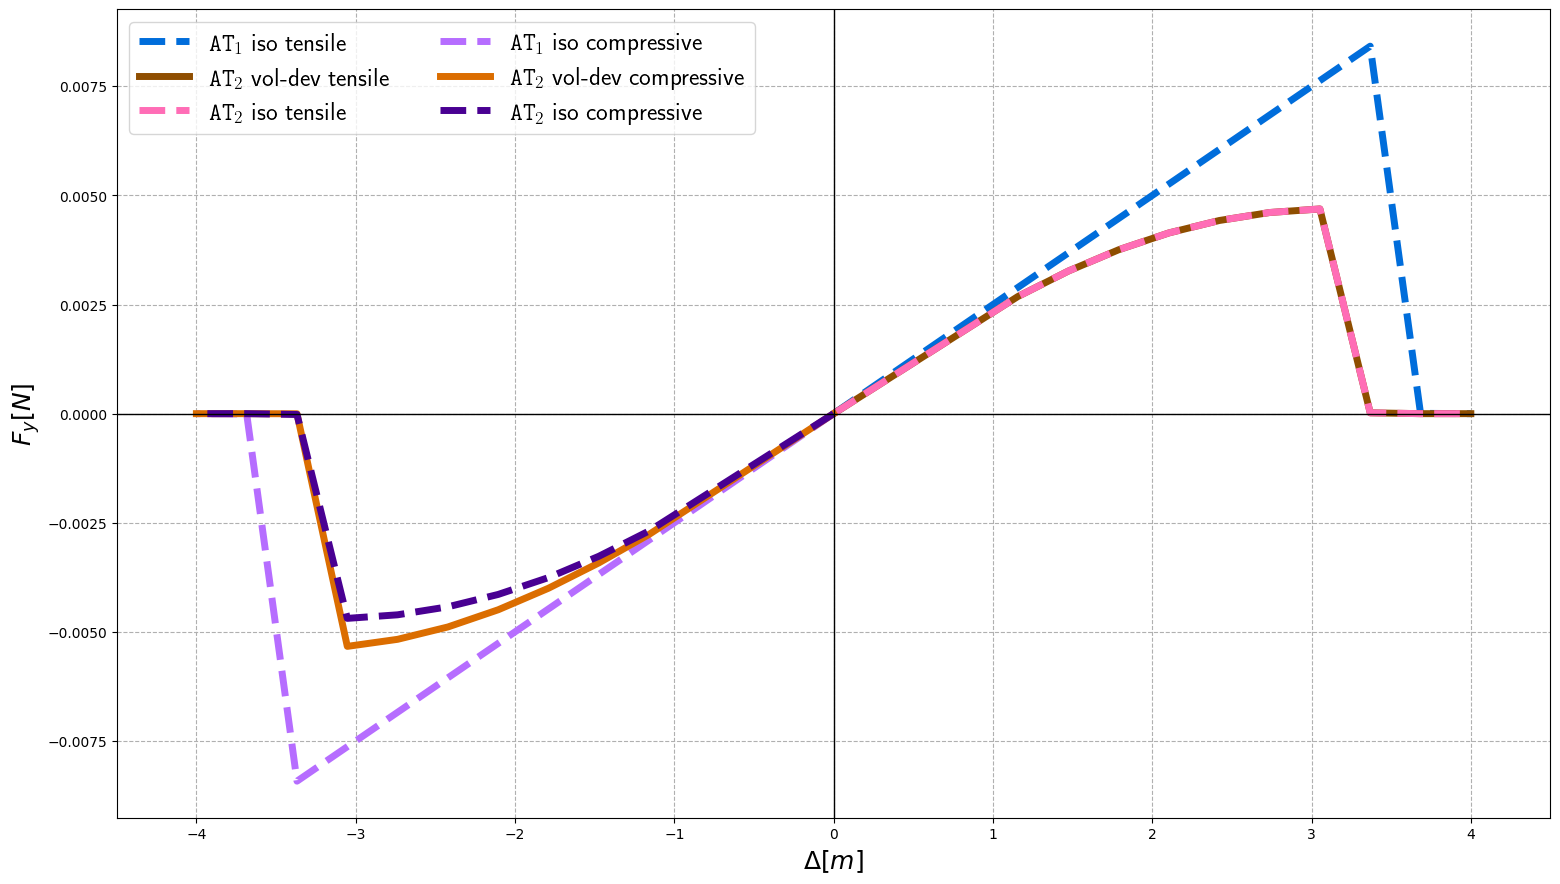

In [6]:
prefixes = [
    "AT1_vd_tensile",
    "AT1_iso_tensile",
    "AT2_vd_tensile",
    "AT2_iso_tensile",
    "AT1_vd_compressive",
    "AT1_iso_compressive",
    "AT2_vd_compressive",
    "AT2_iso_compressive",
]
labels = [
    r"$\texttt{AT}_1$ vol-dev tensile",
    r"$\texttt{AT}_1$ iso tensile",
    r"$\texttt{AT}_2$ vol-dev tensile",
    r"$\texttt{AT}_2$ iso tensile",
    r"$\texttt{AT}_1$ vol-dev compressive",
    r"$\texttt{AT}_1$ iso compressive",
    r"$\texttt{AT}_2$ vol-dev compressive",
    r"$\texttt{AT}_2$ iso compressive",
]
ls = ["-", "--"]
colors = [
    "#ffdf4d",
    "#006ddb",
    "#8f4e00",
    "#ff6db6",
    "#920000",
    "#b66dff",
    "#db6d00",
    "#490092",
]

fig, ax = plt.subplots()
plt.rc("text", usetex=True)
fig.set_size_inches(18.5, 10.5)
for i, pre in enumerate(prefixes):
    pvd = output_dir / f"{pre}.pvd"
    if pvd.is_file():
        curve = force_displ_from_pvd(pvd)
        ax.plot(
            curve[1],
            curve[0],
            ls[i % 2],
            label=labels[i],
            linewidth=5,
            color=colors[i],
            alpha=1,
        )

plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16
ax.grid(linestyle="dashed")
ax.set_xlabel(r"$\Delta [m]$", fontsize=18)
ax.set_ylabel("$F_y [N]$", fontsize=18)
plt.legend(fontsize=18, ncol=2)
ax.axhline(y=0, color="black", linewidth=1)
ax.axvline(x=0, color="black", linewidth=1)
ax.set_xlim(-4.5, 4.5)

Running all the cases with finer timesteps yields the following figure. The failure of the beam in the simulation is observed, when the loading reaches the analytical strength for the corresponding case.
![Results](./figures/beam_result_with_analytical.png "Results")